In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 512
GAMMA = 0.99
LR = 0.0003
EPS = 1e-8

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        q = self.fc(out).reshape(out.shape[0], -1)

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    global action_space
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_acting_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_acting_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## main

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
epsilon_decay = False
# update_frq = int(env.spec.timestep_limit/10)
update_frq = 1
# epsilon = 1.
eps_min = 0.005
# eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

1000

In [7]:
env.spec.reward_threshold

200

In [8]:
env.spec.timestep_limit

1000

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < eps_min:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
#         epsilon -= epsilon * eps_decay
#         epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    53 steps, reward -169.60
  2 Episode in   135 steps, reward -462.55
  3 Episode in   217 steps, reward -403.72
  4 Episode in   269 steps, reward -155.51
  5 Episode in   326 steps, reward -193.80
  6 Episode in   401 steps, reward -461.49
  7 Episode in   454 steps, reward -163.38
  8 Episode in   682 steps, reward -1459.63
  9 Episode in   776 steps, reward -422.00
 10 Episode in   851 steps, reward -485.94
 11 Episode in   940 steps, reward -473.85
 12 Episode in  1013 steps, reward -503.36
 13 Episode in  1099 steps, reward -548.73
 14 Episode in  1181 steps, reward -344.51
 15 Episode in  1277 steps, reward -476.23
 16 Episode in  1459 steps, reward -982.84
 17 Episode in  1610 steps, reward -750.62
 18 Episode in  1710 steps, reward -655.38
 19 Episode in  1786 steps, reward -529.36
 20 Episode in  1869 steps, reward -553.17
 21 Episode in  1947 steps, reward -482.63
 22 Episode in  2128 steps, reward -1094.34
 23 Episode in  2208 steps, reward -474.99
 24 Episo

191 Episode in 15037 steps, reward -210.13
192 Episode in 15104 steps, reward -169.25
193 Episode in 15190 steps, reward -150.05
194 Episode in 15279 steps, reward -227.23
195 Episode in 15348 steps, reward -188.94
196 Episode in 15424 steps, reward -172.08
197 Episode in 15488 steps, reward -210.71
198 Episode in 15547 steps, reward -174.90
199 Episode in 15623 steps, reward -155.60
200 Episode in 15685 steps, reward -215.97
201 Episode in 15745 steps, reward -152.32
202 Episode in 15816 steps, reward -183.14
203 Episode in 15873 steps, reward -182.01
204 Episode in 15954 steps, reward -139.28
205 Episode in 16011 steps, reward -172.30
206 Episode in 16067 steps, reward -163.30
207 Episode in 16131 steps, reward -199.97
208 Episode in 16189 steps, reward -174.68
209 Episode in 16264 steps, reward -200.18
210 Episode in 16335 steps, reward -212.45
211 Episode in 16410 steps, reward -202.31
212 Episode in 16468 steps, reward -182.18
213 Episode in 16540 steps, reward -185.99
214 Episode

382 Episode in 28255 steps, reward -149.65
383 Episode in 28325 steps, reward -194.86
384 Episode in 28412 steps, reward -212.93
385 Episode in 28463 steps, reward -150.35
386 Episode in 28551 steps, reward -146.77
387 Episode in 28610 steps, reward -193.69
388 Episode in 28690 steps, reward -173.90
389 Episode in 28747 steps, reward -144.07
390 Episode in 28830 steps, reward -181.70
391 Episode in 28904 steps, reward -170.35
392 Episode in 28992 steps, reward -352.29
393 Episode in 29063 steps, reward -179.12
394 Episode in 29125 steps, reward -173.28
395 Episode in 29196 steps, reward -187.34
396 Episode in 29263 steps, reward -176.81
397 Episode in 29343 steps, reward -216.49
398 Episode in 29429 steps, reward -44.25
399 Episode in 29491 steps, reward -189.69
400 Episode in 29571 steps, reward -183.01
401 Episode in 29643 steps, reward -214.00
402 Episode in 29697 steps, reward -175.39
403 Episode in 29759 steps, reward -164.29
404 Episode in 29838 steps, reward -150.31
405 Episode 

573 Episode in 42695 steps, reward -1677.21
574 Episode in 42995 steps, reward -1701.73
575 Episode in 43048 steps, reward -230.72
576 Episode in 43104 steps, reward -150.61
577 Episode in 43207 steps, reward -431.09
578 Episode in 43276 steps, reward -193.13
579 Episode in 43597 steps, reward -2103.40
580 Episode in 43682 steps, reward -385.61
581 Episode in 43752 steps, reward -322.35
582 Episode in 43836 steps, reward -407.16
583 Episode in 43913 steps, reward -394.99
584 Episode in 44013 steps, reward -332.25
585 Episode in 44070 steps, reward -323.25
586 Episode in 44137 steps, reward -352.45
587 Episode in 44192 steps, reward -298.72
588 Episode in 44253 steps, reward -345.04
589 Episode in 44341 steps, reward -374.08
590 Episode in 44410 steps, reward -301.50
591 Episode in 44462 steps, reward -300.98
592 Episode in 44542 steps, reward -176.49
593 Episode in 44605 steps, reward -334.55
594 Episode in 44693 steps, reward -277.40
595 Episode in 44749 steps, reward -278.22
596 Epis

764 Episode in 61134 steps, reward -478.50
765 Episode in 61216 steps, reward -392.18
766 Episode in 61304 steps, reward -606.49
767 Episode in 61395 steps, reward -339.08
768 Episode in 61484 steps, reward -617.28
769 Episode in 61569 steps, reward -580.22
770 Episode in 61654 steps, reward -219.09
771 Episode in 61745 steps, reward -438.13
772 Episode in 61826 steps, reward -441.06
773 Episode in 61956 steps, reward -156.49
774 Episode in 62062 steps, reward -297.01
775 Episode in 62129 steps, reward -371.51
776 Episode in 62235 steps, reward -363.07
777 Episode in 62313 steps, reward -539.54
778 Episode in 62465 steps, reward -227.59
779 Episode in 62555 steps, reward -607.89
780 Episode in 62714 steps, reward -306.45
781 Episode in 62818 steps, reward -535.97
782 Episode in 62901 steps, reward -427.55
783 Episode in 62982 steps, reward -390.97
784 Episode in 63073 steps, reward -309.78
785 Episode in 63380 steps, reward -406.37
786 Episode in 63484 steps, reward -456.23
787 Episode

955 Episode in 80193 steps, reward -180.31
956 Episode in 80264 steps, reward -475.00
957 Episode in 80332 steps, reward -141.17
958 Episode in 80384 steps, reward -186.00
959 Episode in 80445 steps, reward -217.66
960 Episode in 80560 steps, reward -40.23
961 Episode in 80637 steps, reward -174.56
962 Episode in 80710 steps, reward -57.78
963 Episode in 80787 steps, reward -454.21
964 Episode in 80855 steps, reward -482.86
965 Episode in 80941 steps, reward -173.34
966 Episode in 81011 steps, reward -228.50
967 Episode in 81105 steps, reward -181.41
968 Episode in 81155 steps, reward -356.84
969 Episode in 81219 steps, reward -233.00
970 Episode in 81301 steps, reward -179.04
971 Episode in 81364 steps, reward -166.75
972 Episode in 81446 steps, reward -146.40
973 Episode in 81512 steps, reward -181.57
974 Episode in 81563 steps, reward -159.17
975 Episode in 81621 steps, reward -183.21
976 Episode in 81703 steps, reward -163.32
977 Episode in 81789 steps, reward -183.98
978 Episode i

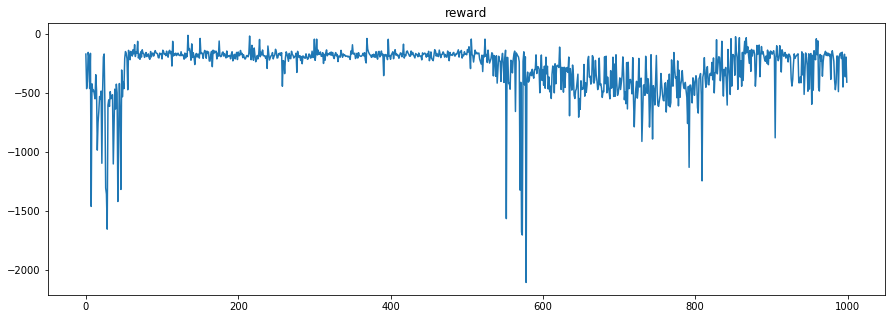

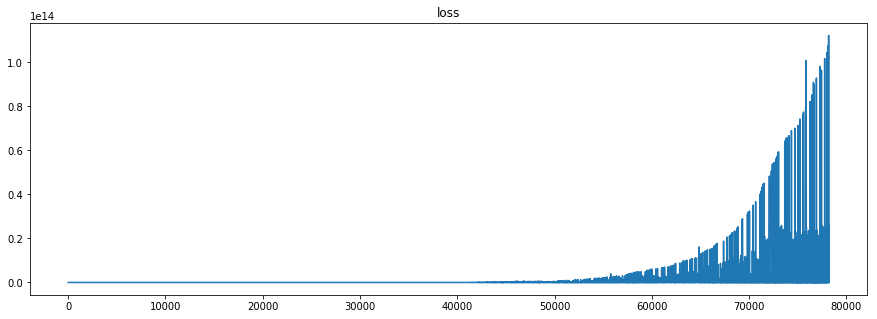

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()